<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/3_3_Spotify_songs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spotify songs**

Se desarrolla un **clasificador k vecinos más cercanos (knn)** para predecir si una canción dada va a ser gustada o no. Se implementará un **dataset con más de 2000 canciones de Spotify de un usuario**, donde algunas fueron marcadas como gustadas y otras no.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

## **1. Dataset**

Primero se lee y visualiza el dataset a trabajar

In [ ]:
spotify_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
spotify_data.head(n=10)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
5,5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,1,Sneakin’,Drake
6,6,0.01450,0.739,241400,0.472,0.000007,1,0.2070,-11.204,1,0.1560,80.030,4.0,0.308,1,Childs Play,Drake
7,7,0.02020,0.266,349667,0.348,0.664000,10,0.1600,-11.609,0,0.0371,144.154,4.0,0.393,1,Gyöngyhajú lány,Omega
8,8,0.04810,0.603,202853,0.944,0.000000,11,0.3420,-3.626,0,0.3470,130.035,4.0,0.398,1,I've Seen Footage,Death Grips
9,9,0.00208,0.836,226840,0.603,0.000000,7,0.5710,-7.792,1,0.2370,99.994,4.0,0.386,1,Digital Animal,Honey Claws


Se elimina la columna ***'Unnamed: 0'*** ya que es solo el índice de cada observación. Seguido, se obtienen los atributos (también estandarizados) y la columna objetivo.

In [ ]:
spotify_data = spotify_data.drop(columns='Unnamed: 0')

# Encodes some features from categorical to numercial
le = LabelEncoder()
spotify_data['song_title'] = le.fit_transform(spotify_data['song_title'])
spotify_data['artist'] = le.fit_transform(spotify_data['artist'])

# Get features and target
X = spotify_data.drop(columns='target').to_numpy()
y = spotify_data['target'].to_numpy()

# Get feature standardized
scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)

Primero se realiza un análisis paramétrico con todo el dataset y luego se explora el comportamiento del modelo ante la eliminación de algunos atributos que no aportan mayor información.

## **2. Datos de entrenamiento y prueba**

Se obtiene la división de los datos para entrenamiento y prueba con diferentes proporciones.

In [ ]:
# All splits with different train sizes
splits = {'Train 80%': {'Original split':0, 
                        'Scaled split':0},
          
          'Train 50%': {'Original split':0, 
                        'Scaled split':0},
          
          'Train 30%': {'Original split':0, 
                        'Scaled split':0}}

# Test sizes of each split to create
test_sizes = [0.2, 0.5, 0.7]

# Create the splits
splits_keys = list(splits.keys())
for index in range(len(test_sizes)):

  test_size = test_sizes[index]
  split_name = splits_keys[index]

  # Splits the features and target in train and test data
  # X_train, X_test, y_train, y_test
  splits[split_name]['Original split'] = train_test_split(X, y, test_size=test_size, random_state=4)
  splits[split_name]['Scaled split'] = train_test_split(X_norm, y, test_size=test_size, random_state=4)

## **3. Ajuste de hiperparámetros**

Para cada division realizada, se procede a implementar un ajuste de hiperparámetros mediante `GridSearch`.

In [ ]:
def apply_GridSearch(X_train, y_train):
  '''
  Evaluates the grid search of a KNN model and returns an object of 
  <sklearn.model_selection.GridSearchCV> with all attributes of the 
  grid applied.
  '''

  # Model to apply GridSearch
  model = KNeighborsClassifier()

  # Grid params to evaluate
  parameters = {
      'n_neighbors': [n for n in range(3, 150)],
      'weights': ['uniform', 'distance'],
      'metric': ['chebyshev', 'manhattan', 'minkowski']
  }

  # Applies the Grid Search
  grid_search = GridSearchCV(model, parameters, cv=5, return_train_score=False)
  grid_search.fit(X_train,y_train)

  return grid_search

In [ ]:
# Execution time: 5min 45s
for split_name, split_data in splits.items():

  # Get Train-Test splits
  # [X_train, X_test, y_train, y_test]
  data = split_data['Original split']
  scaled_data = split_data['Scaled split']

  splits[split_name]['Original grid'] = apply_GridSearch(data[0], data[2])
  splits[split_name]['Scaled grid'] = apply_GridSearch(scaled_data[0], scaled_data[2])

## **4. Resultados de entrenamiento**

Obtenido lo anteior, se procede a analizar los resultados de cada GridSearch.

In [ ]:
def show_results(grid_object, top_ten=True):
  '''
  Display a summary of the results gotten on a grid search.
  '''

  # Reads the results as a DataFrame
  results = pd.DataFrame(grid_object.cv_results_)

  # Gets the params values and its mean test score
  grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]


  print("El mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(round(grid_object.best_score_, 3), 
                                                                              grid_object.best_params_['metric'],
                                                                              grid_object.best_params_['weights'], 
                                                                              grid_object.best_params_['n_neighbors']))

  # Display plots
  fig, axs = plt.subplots(1, 3, figsize=(17,4))

  axs[0].set_title('Gráfica 1')
  sns.lineplot(x='param_n_neighbors', 
              y='mean_test_score', 
              ci=None, 
              hue='param_weights', 
              data=grid_summary,
              ax=axs[0])
  axs[0].set_xlabel('k vecinos más cercanos')
  axs[0].set_ylabel('Puntaje medio de prueba')

  axs[1].set_title('Gráfica 2')
  sns.lineplot(x='param_n_neighbors', 
              y='mean_test_score', 
              ci=None, 
              hue='param_metric', 
              data=grid_summary,
              ax=axs[1])
  axs[1].set_xlabel('k vecinos más cercanos')
  axs[1].set_ylabel('Puntaje medio de prueba')

  axs[2].set_title('Gráfica 3')
  sns.barplot(x="param_metric", 
              y="mean_test_score", 
              hue="param_weights", 
              data=grid_summary,
              ax=axs[2])
  axs[2].set_xlabel('Parámetro "metric"')
  axs[2].set_ylabel('Puntaje medio de prueba')

  plt.show()


  # Get the top best scores
  if top_ten:
    print('\n', '-'*30, '\nTop 10 mejores combinaciones:\n', '-'*30)
    print(grid_summary.sort_values(by='mean_test_score', ascending=False, ignore_index=True).head(n=10))

### **4.1. Train: 80%**

------------------------------
Datos originales (Train 80%)
------------------------------
El mejor puntaje es 0.596 con metric: minkowski, weight: distance y k = 60



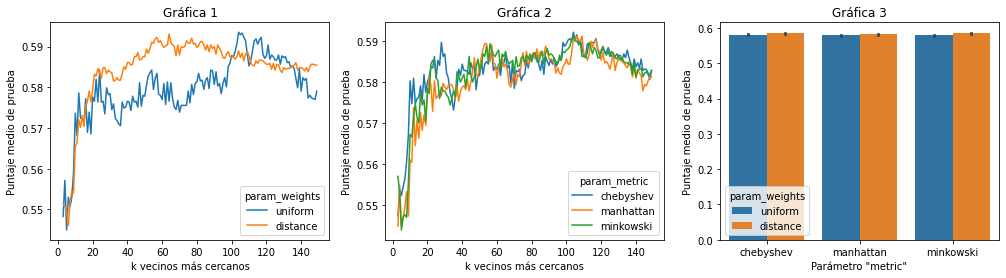


 ------------------------------
Datos estandarizados (Train 80%)
------------------------------
El mejor puntaje es 0.722 con metric: manhattan, weight: distance y k = 22



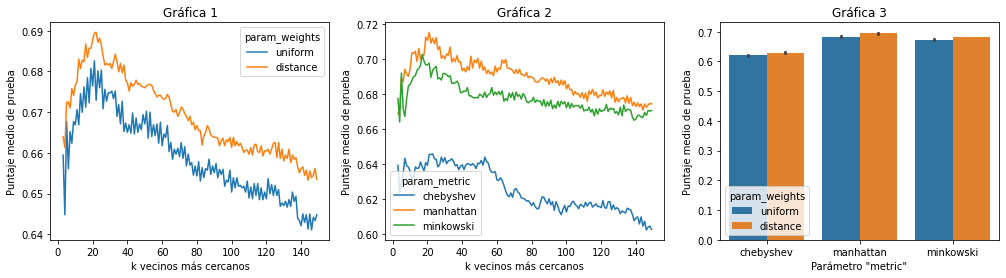

In [ ]:
# Gets the GridSearch object for train = 80%
split_name = 'Train 80%'

print('-'*30)
print(f'Datos originales ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Original grid']
show_results(grid_object, top_ten=False)

print('\n', '-'*30)
print(f'Datos estandarizados ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Scaled grid']
show_results(grid_object, top_ten=False)

**ANÁLISIS**

- Para este primer *split* se observa que se obtienen **mejores puntajes para los datos estandarizados** (0.72 en comparación de 0.59).

- En la evaluación con los atributos estandarizados, se observa que el parámetro `metric = 'chebyshev'` presenta un **puntaje notablemente inferior** respecto las demás opciones (*manhattan* y  *minkowski*).

- Con los datos estandarizados, también se observa que para el parámetro `weight = 'uniform'` el modelo presenta un comportamiento inferior respecto a `weight = 'distance'`.

- Se destaca que para la `gráfica 3`, tanto para los datos originales como estandarizados, no se observa diferencia significatica en el puntaje de prueba. 

### **4.1. Train: 50%**

------------------------------
Datos originales (Train 50%)
------------------------------
El mejor puntaje es 0.587 con metric: minkowski, weight: uniform y k = 44



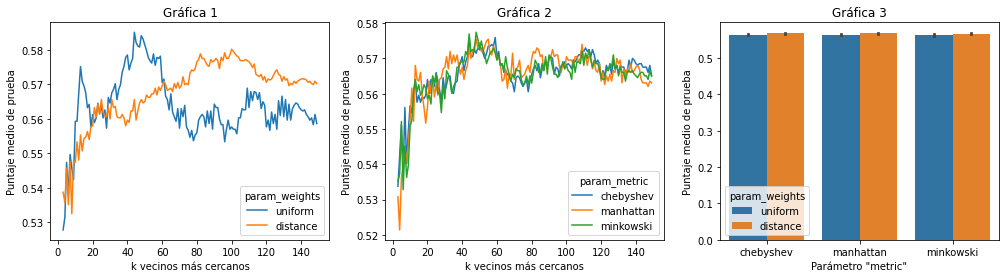


 ------------------------------
Datos estandarizados (Train 50%)
------------------------------
El mejor puntaje es 0.703 con metric: manhattan, weight: distance y k = 18



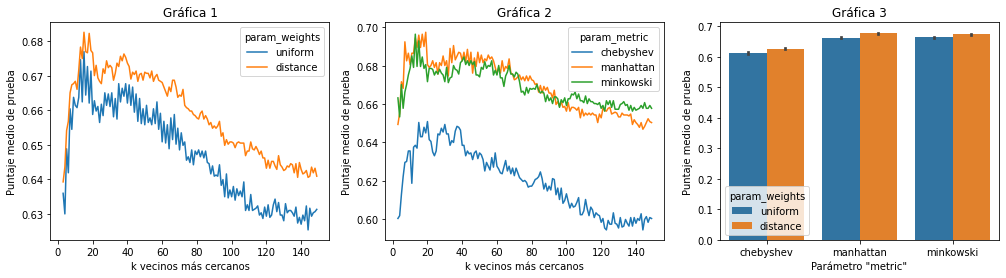

In [ ]:
# Gets the GridSearch object for train = 50%
split_name = 'Train 50%'

print('-'*30)
print(f'Datos originales ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Original grid']
show_results(grid_object, top_ten=False)

print('\n', '-'*30)
print(f'Datos estandarizados ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Scaled grid']
show_results(grid_object, top_ten=False)

**ANÁLISIS**

- El comportamiento, en general, es muy similar al observado para el *split* anterior (Train 80%).

- Se destaca que, para la `gráfica 1` de los datos originales, el puntaje del parámetro `weights` es favorable para ambos valores implementados (`uniform`y `distance`) dependiendo de la cantidad de vecinos (`n_neighbors`)

### **4.1. Train: 30%**

------------------------------
Datos originales (Train 30%)
------------------------------
El mejor puntaje es 0.612 con metric: minkowski, weight: uniform y k = 36



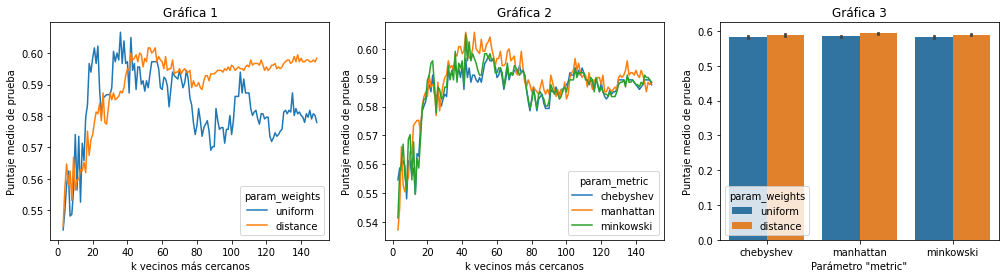


 ------------------------------
Datos estandarizados (Train 30%)
------------------------------
El mejor puntaje es 0.714 con metric: manhattan, weight: distance y k = 8



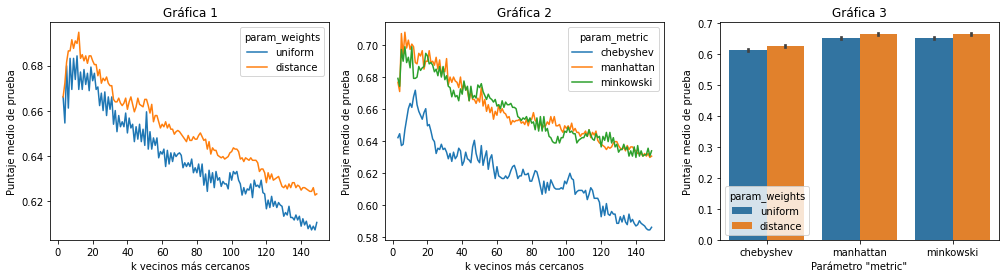

In [ ]:
# Gets the GridSearch object for train = 30%
split_name = 'Train 30%'

print('-'*30)
print(f'Datos originales ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Original grid']
show_results(grid_object, top_ten=False)

print('\n', '-'*30)
print(f'Datos estandarizados ({split_name})')
print('-'*30)
grid_object = splits[split_name]['Scaled grid']
show_results(grid_object, top_ten=False)

**ANÁLISIS**

- Un aspecto a resaltar es que, para los datos estandarizados, en las gráficas `gráfica 1` y `gráfica 2`, los puntajes de los valores con la linea azul (`uniform` y `chebyshev`) presentan puntajes más cercanos a sus otros valores a comparación de los otros splits.

## **5. Resultados de prueba**

Entrenado cada uno de los modelos y habiendo sus ajustado sus hiperparámetros, se procede a obtener el mejor modelo de cada caso y evaluarlo con los datos de prueba.

In [ ]:
test_results1 = []
for split_name, split_data in splits.items():

  # Get Train-Test splits
  # [X_train, X_test, y_train, y_test]
  X_train, X_test, y_train, y_test = split_data['Original split']
  X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = split_data['Scaled split']

  # Get the GridSearch objects
  grid = splits[split_name]['Original grid']
  grid_scaled = splits[split_name]['Scaled grid']

  # Get the model that got the best performance
  model = grid.best_estimator_
  model_scaled = grid_scaled.best_estimator_

  # Calculates predictions
  y_pred = model.predict(X_test)
  y_pred_scaled = model_scaled.predict(X_test_scaled)

  # Calculates accuracy
  score = round(accuracy_score(y_test, y_pred), 3)
  score_scaled = round(accuracy_score(y_test_scaled, y_pred_scaled), 3)

  # Get the params of the best model in GridSearch
  print(f'Hiperparámetros ({split_name})')
  print('-'*30)
  print('Original:', grid.best_params_)
  print('Scaled:', grid_scaled.best_params_)
  print('-'*30, '\n')

  # Appends results
  test_results1.append((split_name, score, score_scaled))

print('\nResultados de prueba')
print('-'*30)
test_summary1 = pd.DataFrame(test_results1, columns=['Split', 'Original', 'Scaled'])
test_summary1

Hiperparámetros (Train 80%)
------------------------------
Original: {'metric': 'minkowski', 'n_neighbors': 60, 'weights': 'distance'}
Scaled: {'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'distance'}
------------------------------ 

Hiperparámetros (Train 50%)
------------------------------
Original: {'metric': 'minkowski', 'n_neighbors': 44, 'weights': 'uniform'}
Scaled: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
------------------------------ 

Hiperparámetros (Train 30%)
------------------------------
Original: {'metric': 'minkowski', 'n_neighbors': 36, 'weights': 'uniform'}
Scaled: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
------------------------------ 


Resultados de prueba
------------------------------


,Split,Original,Scaled
0,Train 80%,0.601,0.723
1,Train 50%,0.593,0.707
2,Train 30%,0.556,0.670


**ANÁLISIS**

- Dentro de las mejores combinaciones de hiperparámetros, `n_neighbors` es proporcional a la cantidad de datos para entrenamientos.

- Los valores del parámetro `metric`, tanto para los datos estandarizados como originales, es el mismo y no cambia respecto a la proporción de datos para entrenamiento.

- Se observan **mejores puntajes para los datos estandarizados**.

- Conforme se aumenta la proporción de datos para entrenamiento, incrementa la exactitud del mejor modelo de cada GridSearch.

## **6. Selección de atributos**

Una vez conocido el comportamiento del modelo manteniendo todos los atributos, se realizará un análisis para conocer cuál de los incluidos pueden ser omitidos y posterior a ello se vuelve a evaluar el modelo y su resultado.

### **6.1. Correlación**

Se procede a conocer la correlación de los atributos. El objetivo es encontrar aquellos que aporten menor información respecto a la columna objetivo y los que tengan un comportamiento similar entre sí.

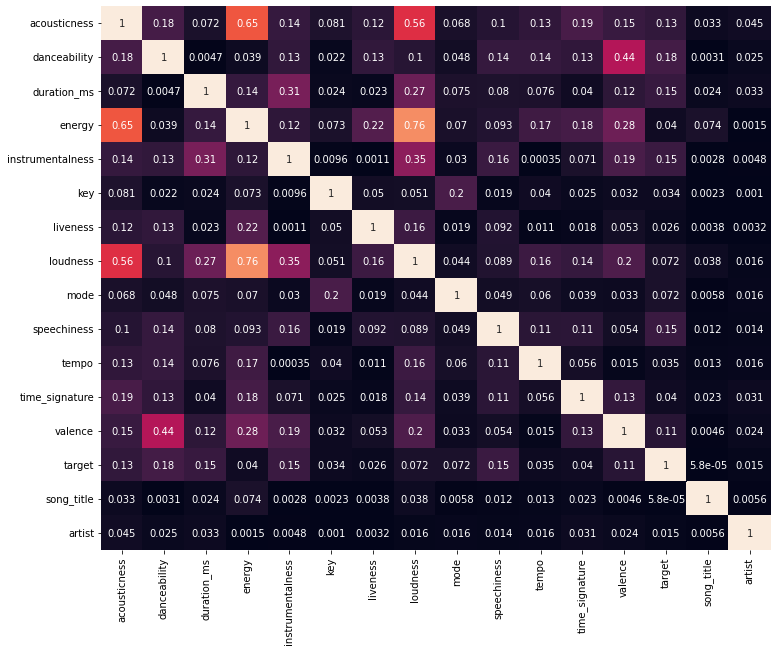

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(spotify_data.corr().abs(), annot=True, cbar=False)
plt.show()

- En general, los atributos del dataset presentan una correlación baja. Los únicos que presenta un valor relativamente alto son `energy` y `loudness` con un valor de 0,76.

- Se observa que las variables como `song_title`, `artist`, `liveness` y `key` son los atributos que menor correlación presentan respecto a la columna a predecir. Esto podría ser un indicio a las posibles columnas a eliminar ya que, presuntamente, no aportarían mayor información. 

In [ ]:
# Get features variance
feat_var = spotify_data.drop(columns='target').var().sort_values(ascending=False)
feat_var

duration_ms         6.721018e+09
song_title          3.180996e+05
artist              1.512176e+05
tempo               7.121214e+02
loudness            1.415027e+01
key                 1.330966e+01
mode                2.375075e-01
instrumentalness    7.461758e-02
acousticness        6.759442e-02
time_signature      6.546094e-02
valence             6.110560e-02
energy              4.421474e-02
danceability        2.593033e-02
liveness            2.416569e-02
speechiness         8.087668e-03
dtype: float64

- `speechiness` es el atributo con menor varianza de todas. Esto podría indicar que no genera mayor importancia para le modelo, ya que varía muy poco.

Sin embargo, ahora se realiza un análisis a partir de otros modelos para tomar una decisión.

### **6.2. Árbol de decisión**

Ahora se evaluarán los atributos a partir de un árbol de decisión para conocer el nivel de importancia.

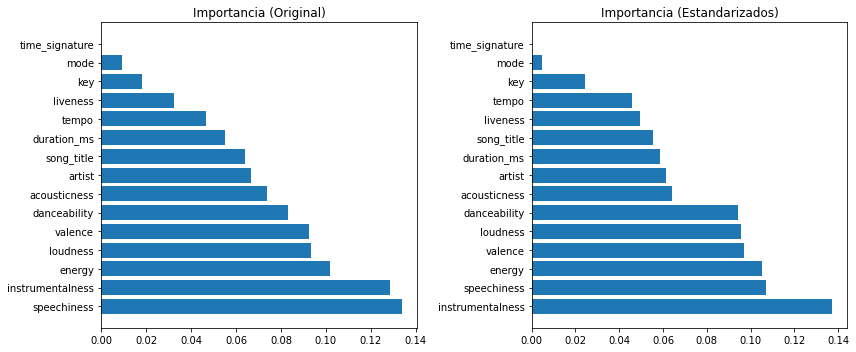

In [ ]:
from sklearn.tree import DecisionTreeClassifier

fig, axs = plt.subplots(1, 2, figsize=(12,5))

feature_names = np.array(spotify_data.drop(columns='target').columns)
index = 0
feat_titles = ['Original', 'Estandarizados']
for features in [X, X_norm]:
  dummy_tree = DecisionTreeClassifier(criterion="gini")
  dummy_tree.fit(features,y)

  importance = dummy_tree.feature_importances_

  feats = {}
  for name, imp in zip(feature_names, importance):
    feats[name] = imp

  feats_serie = pd.Series(feats).sort_values(ascending=False)

  axs[index].barh(width=feats_serie.values, y=feats_serie.index)
  axs[index].set_title(f'Importancia ({feat_titles[index]})')

  index += 1

plt.tight_layout()
plt.show()

* Si bien, para la correlación y varianza de los atributos, se encontraron que `energy`, `loudness`, `acousticness` y `speechiness` podrían ser posibles features a eliminar; según el arbol de desición estos se encuentran dentro de un rango significativo de importancia.

* La importancia para las features varia un poco entre los datos originales y estandarizados.

### **6.3. LassoCV**

Ahora se implementa un análisis a partir del estimador LassoCV.

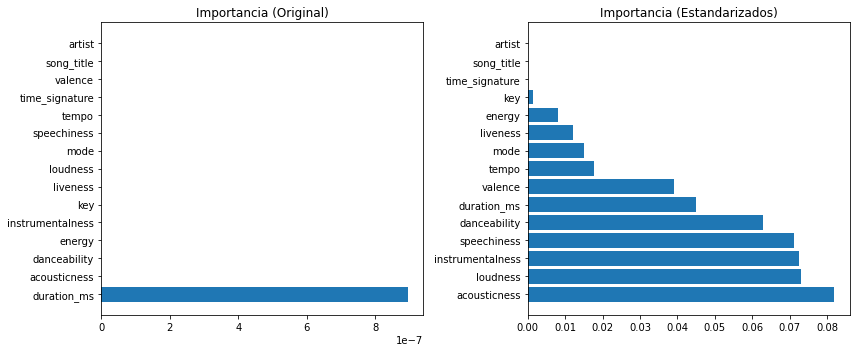

In [ ]:
from sklearn.linear_model import LassoCV

fig, axs = plt.subplots(1, 2, figsize=(12,5))

feature_names = np.array(spotify_data.drop(columns='target').columns)
index = 0
feat_titles = ['Original', 'Estandarizados']
for features in [X, X_norm]:

  lasso = LassoCV().fit(features, y)
  importance = np.abs(lasso.coef_)

  feats = {}
  for name, imp in zip(feature_names, importance):
    feats[name] = imp

  feats_serie = pd.Series(feats).sort_values(ascending=False)

  axs[index].barh(width=feats_serie.values, y=feats_serie.index)
  axs[index].set_title(f'Importancia ({feat_titles[index]})')

  index += 1


plt.tight_layout()
plt.show()

* Para los datos originales el atributo `duration_ms` es el único que presenta importancia, según el modelo implementado.

## **7. Nuevos atributos**

A partir del anterior análisis, se omiten algunos atributos y se observa si este cambio afecta en pro el comportamiento del modelo.

Ya que el split con mejores resultados fue con 80% de entrenamiento, se mantiene esa proporción para las siguientes pruebas.

In [ ]:
decision_tree_feats = spotify_data.drop(columns=['target', 'time_signature']).columns
lasso_feats = spotify_data.drop(columns=['target', 'artist', 'time_signature', 'song_title']).columns
general_feats = spotify_data.drop(columns=['target', 'energy', 'speechiness']).columns

datasets = {'Decision Tree': {'Original split':0, 
                              'Scaled split':0},
            
            'Lasso': {'Original split':0, 
                      'Scaled split':0},
            
            'General': {'Original split':0, 
                        'Scaled split':0}}

datasets_keys = list(datasets.keys())
for dataset_name in datasets.keys():

  if dataset_name == 'Lasso':
    columns = lasso_feats
  elif dataset_name == 'General':
    columns = general_feats
  else:
    columns = decision_tree_feats

  # Get features and target
  X = spotify_data[columns].to_numpy()
  y = spotify_data['target'].to_numpy()

  # Get feature standardized
  scaler = StandardScaler().fit(X)
  X_norm = scaler.transform(X)

  # Splits the features and target in train and test data
  # X_train, X_test, y_train, y_test
  datasets[dataset_name]['Original split'] = train_test_split(X, y, test_size=0.2, random_state=4)
  datasets[dataset_name]['Scaled split'] = train_test_split(X_norm, y, test_size=0.2, random_state=4)

## **7. Análisis final**

Finalmente se obtiene el comportamiento de los mejores modelos con los nuevos atributos elegidos para cada caso. 

Esta vez, se aplica un GridSearch con 80% de los datos para entrenamiento, ya que arrojó un leve mejor comportamiento respecto a las demás divisiones.


In [ ]:
# Execution time: 8min 21s
test_results2 = []
for dataset_name, dataset_type in datasets.items():

  # Get Train-Test splits
  # [X_train, X_test, y_train, y_test]
  X_train, X_test, y_train, y_test = dataset_type['Original split']
  X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = dataset_type['Scaled split']

  # Get GridSearch objects
  grid = apply_GridSearch(X_train, y_train)
  grid_scaled = apply_GridSearch(X_train_scaled, y_train_scaled)

  # Save GridSearch objects to `datasets` dictionary
  datasets[dataset_name]['Original grid'] = grid
  datasets[dataset_name]['Scaled grid'] = grid_scaled

  # Get the model that got the best performance
  model = grid.best_estimator_
  model_scaled = grid_scaled.best_estimator_

  # Calculates predictions
  y_pred = model.predict(X_test)
  y_pred_scaled = model_scaled.predict(X_test_scaled)

  # Calculates and save the accuracy
  score = round(accuracy_score(y_test, y_pred), 3)
  score_scaled = round(accuracy_score(y_test_scaled, y_pred_scaled), 3)
  test_results2.append((dataset_name, score, score_scaled))

print('\nResultados con todos los atributos')
print('-'*40)
print(test_summary1)

print('\nResultados con reducción de atributos')
print('-'*40)
test_summary2 = pd.DataFrame(test_results2, columns=['Dataset', 'Original', 'Scaled'])
print(test_summary2)


Resultados con todos los atributos
----------------------------------------
       Split  Original  Scaled
0  Train 80%     0.601   0.723
1  Train 50%     0.593   0.707
2  Train 30%     0.556   0.670

Resultados con reducción de atributos
----------------------------------------
         Dataset  Original  Scaled
0  Decision Tree     0.601   0.730
1          Lasso     0.592   0.720
2        General     0.601   0.686


Como se observa, a comparación del los modelos obtenidos con todos los atributos, se obtiene un comportamiento levemente mejor con una exactitud de 0,73 respecto a un 0,72.

## **Conclusión**

- Se logra obtener una **exactitud de 0,73** luego de eliminar el atributo `time_signature` basado en la importancia dada en un árbol de decisión (con un 80% de datos para entrenamiento).

- Los resultados muestran un **mejor comportamiento utilizando el 80% de los datos para entrenamiento**.

- Otra manera de evaluar el comportamiento del modelo ante la adición o eliminación de atributos es con la librería [Secuencial Feature Selector](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector) de Mlxtend o a partir de los ejemplos mostrados en [Feature Selection | Sklearn](https://scikit-learn.org/stable/modules/feature_selection.html)

- Se contrastó el comportamiento tanto para los datos sin procesar como para los estandarizados. En este caso se elige trabajar con los segundos ya que arrojaron mejores comportamientos para el modelo.
